# Einführung in OpenCV 

In [1]:
import imageio
import cv2
import numpy as np
from matplotlib import pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\mkastner\AppData\Local\Continuum\anaconda3\envs\ml-hype-or-hybris\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Beispielbilder werden mit imageio frei verschifft.
Für die Übersicht der Bilder siehe [hier](https://imageio.readthedocs.io/en/latest/standardimages.html).

Zunächst wird das Bild mithilfe von matplotlib visualisiert, das eine gute Integration mit Jupyter Notebooks hat.
[Hier](https://medium.com/@mrdatainsight/how-to-use-opencv-imshow-in-a-jupyter-notebook-quick-tip-ce83fa32b5ad) gibt es weiterführende Informationen, wobei es bei OpenCV hakelt.

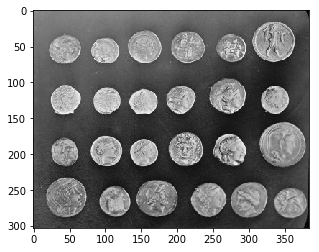

In [2]:
gray_image = imageio.imread("imageio:coins.png")
plt.imshow(gray_image, cmap="gray")
plt.show()

Nun ist bereits thematisiert worden, dass Bilder Matrizen mit Zahlenwerten sind.
Es gibt verschiedene Darstellungsformen, weswegen wir nun schauen, welche hier vorliegt.

In [3]:
gray_image.min(), gray_image.max()

(1, 252)

Die Verteilung der Intensitätswerte kann man sich über ein Histogramm verdeutlichen.

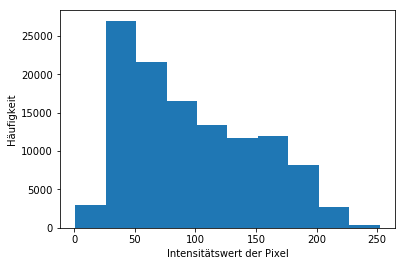

In [4]:
plt.hist(gray_image.flatten())
plt.ylabel("Häufigkeit")
plt.xlabel("Intensitätswert der Pixel")
plt.show()

$\rightarrow$ Es ist die Darstellung zwischen 0 und 255 - die Zahlen repräsentieren die Intensitätswerte.

## Canny-Filter

Aber wie kann man nun die Münzen automatisiert detektieren?
Der Fragezeichenoperator ruft die Dokumentation einer Klasse oder einer Funktion auf.

In [5]:
?cv2.Canny

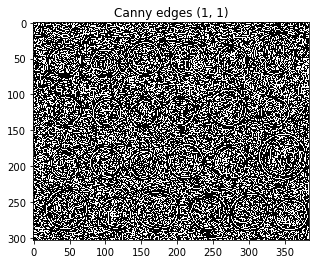

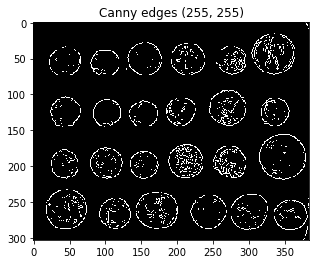

In [6]:
edged_1 = cv2.Canny(gray_image, 1, 1)
plt.title('Canny edges (1, 1)')
plt.imshow(edged_1, cmap="gray")
plt.show()

edged_2 = cv2.Canny(gray_image, 255, 255)
plt.title('Canny edges (255, 255)')
plt.imshow(edged_2, cmap="gray")
plt.show()

Finden Sie nun Werte für den Canny-Filter, mit dem man die Münzen am besten vom Hintergrund automatisch ausschneiden könnte.
Die Verwendung einer `for`-Schleife kann dabei helfen, schneller mehr Filter auszuprobieren.

In [7]:
# Probieren Sie sich hier aus

## Blob-Detektor

Um Objekte zu identifizieren, gibt es bereits von Haus aus Werkzeuge wie den Blob-Detektor.
Dieser ermittelt, wo gleichartige Flächen sind.

In [8]:
detector = cv2.SimpleBlobDetector_create()
keypoints = detector.detect(gray_image)

[k.pt for k in keypoints]

[(288.5005187988281, 61.98678207397461),
 (101.73904418945312, 195.2291259765625)]

Dies kann man nun auch in das Bild einzeichnen

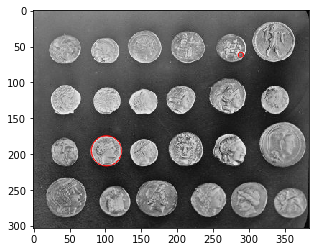

In [9]:
blobs = cv2.drawKeypoints(
    gray_image, 
    keypoints, 
    np.zeros((1,1)), 
    (255, 0, 0), 
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.imshow(blobs)
plt.show()

Das Ergebnis ist noch nicht ganz überzeugend.
Die zwei Punkte sind eingezeichnet worden - 
der eine Blob ist eine Münze, der zweite aber nur ein kleiner Ausschnitt auf der zweiten Münze von rechts oben.

Die Standard-Parameter, die verwendet werden, wenn keine Werte angegeben werden, sind vielleicht nicht so gut geeignet.
Nun passen wir manuell einzelne Parameter an.
Weitere Informationen zur API von OpenCV gibt es [online](https://docs.opencv.org/3.4/d0/d7a/classcv_1_1SimpleBlobDetector.html), Beispiele bei stackoverflow.

In [10]:
params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.filterByCircularity = False
params.filterByColor = True
params.filterByConvexity = False
params.filterByInertia = False

params.minArea = 250
params.minThreshold = 15
params.minDistBetweenBlobs = 10

detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(gray_image)
[(i + 1, k.pt) for i, k in enumerate(keypoints)]

[(1, (44.48649978637695, 254.5546112060547)),
 (2, (250.15623474121094, 261.45794677734375)),
 (3, (276.880126953125, 55.16391372680664)),
 (4, (101.73062896728516, 195.11581420898438)),
 (5, (339.9984130859375, 43.08913803100586)),
 (6, (102.34709167480469, 124.97407531738281)),
 (7, (148.03671264648438, 127.42520141601562))]

Auch dies können aufgrund der zu geringen Anzahl nicht die 24 Münzen sein.

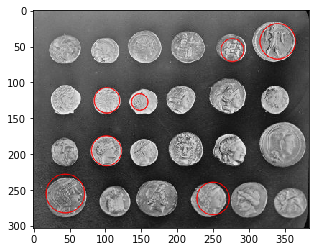

In [11]:
blobs = cv2.drawKeypoints(
    gray_image, 
    keypoints,
    np.zeros((1,1)), 
    (255, 0, 0), 
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.imshow(blobs)
plt.show()

Auch hier gibt es noch viele Baustellen:
Manche Münzen werden gar nicht erkannt, manchmal werden nur Teile der Münze eingekreist u. ä.
Dabei gibt es für den Blob-Detektor [gute Beispiele](https://www.learnopencv.com/blob-detection-using-opencv-python-c/) dafür, dass die Methode an sich funktioniert.

## Verknüpfe Canny-Filter und Blob-Detektor

Nun kann man die Stärken verschiedener Methoden miteinander kombinieren.
So kann man auch den Filter und den Detektor nacheinander ausführen.
Das Bild wird zuerst gefiltert und der Detektor wird mit dem gefilterten Bild aufgerufen.

In [12]:
params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.filterByCircularity = True
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False

params.minArea = 150
params.minThreshold = 5
params.minDistBetweenBlobs = 5
params.minCircularity = 0.3

detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(edged_2)
[(i + 1, k.pt) for i, k in enumerate(keypoints)]

[(1, (113.7923355102539, 265.4548034667969)),
 (2, (300.5699157714844, 263.1999206542969)),
 (3, (172.38250732421875, 261.2099304199219)),
 (4, (45.88734436035156, 259.75946044921875)),
 (5, (154.09815979003906, 197.75555419921875)),
 (6, (101.70194244384766, 195.5152130126953)),
 (7, (212.42047119140625, 193.0865478515625)),
 (8, (347.02093505859375, 186.74073791503906)),
 (9, (153.59091186523438, 127.25402069091797)),
 (10, (102.29440307617188, 125.6087646484375)),
 (11, (336.2676696777344, 124.35457611083984)),
 (12, (205.24070739746094, 123.79837799072266)),
 (13, (44.6766471862793, 124.29364776611328)),
 (14, (270.6104736328125, 118.7294692993164)),
 (15, (100.15635681152344, 56.14109420776367)),
 (16, (334.6490478515625, 43.56333923339844))]

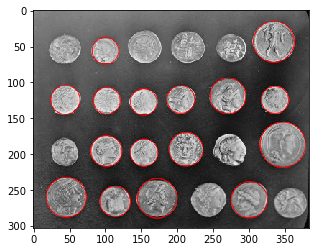

In [13]:
blobs = cv2.drawKeypoints(
    gray_image, 
    keypoints,
    np.zeros((1,1)), 
    (255, 0, 0), 
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.imshow(blobs)
plt.show()

Nun gibt es verschiedene Möglichkeiten, wie man weiterarbeiten kann.
Die Parameter können nun weiter "getunt" werden, d. h. weiter anpassen, bis das gewünschte Ergebnis erreicht wird.
Allerdings können auch der Filter und der Detektor ausgetauscht werden.
OpenCV bietet viel mehr Möglichkeiten, und es gibt auch weitere Bibliotheken.
Mit der Bibliothek `numpy` kann man sogar selbst Filter und Detektoren implementieren.

Haben Sie eine Hypothese, weswegen das Erkennen der Münzen auf dem Bild so schwierig ist?
Wie würden Sie in Zukunft den Prozess der Bildaufnahme gestalten, um die Erkennung der Münze zu vereinfachen?

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Lizenzvertrag" style="border-width:0; display:inline" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a> &nbsp;&nbsp;&nbsp;&nbsp;Dieses Werk von Marvin Kastner ist lizenziert unter einer <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Namensnennung 4.0 International Lizenz</a>.